<a href="https://colab.research.google.com/github/Wairioko/User_Valuation/blob/main/Customer_Valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime
from collections import Counter

In [22]:
data = pd.read_csv('/content/data.csv' )
# remove areas where customer id is null...
# probably cash buys/unregistered customers

print(data.columns)
data.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T
data['Quantity'].dtype
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True)
# Calculate the recency by subtracting the 'InvoiceDate' from today's date
today = datetime.now().date()  # Get today's date
data['Recency'] = (today - data['InvoiceDate'].dt.date).dt.days

data.head

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Custom

                 average
Country                 
Australia           35.0
Austria             12.0
Bahrain              0.0
Belgium             15.0
Channel Islands      7.0
Cyprus               8.0
Denmark             23.0
EIRE                21.0
Finland             72.0
France              13.0
Germany             11.0
Greece              16.0
Hong Kong           20.0
Iceland             11.0
Israel               3.0
Italy                9.0
Japan               46.0
Lebanon              9.0
Lithuania           19.0
Netherlands         86.0
Norway              23.0
Poland              12.0
Portugal            12.0
Singapore           19.0
Spain               10.0
Sweden              95.0
Switzerland         17.0
United Kingdom       8.0


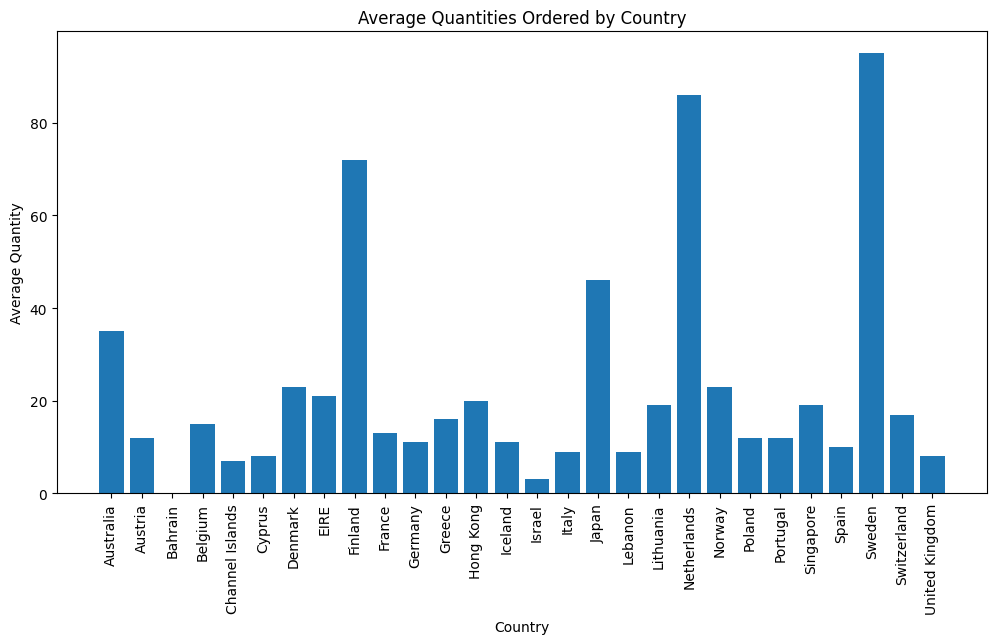

In [4]:
# get average quantities ordered by country
countries_grouped = data.groupby('Country')
quantity_by_country = round(countries_grouped['Quantity'].agg([np.average]))
print(quantity_by_country)
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(quantity_by_country.index, quantity_by_country['average'])

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Average Quantity')
plt.title('Average Quantities Ordered by Country')

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=90)

# Show the plot
plt.show()


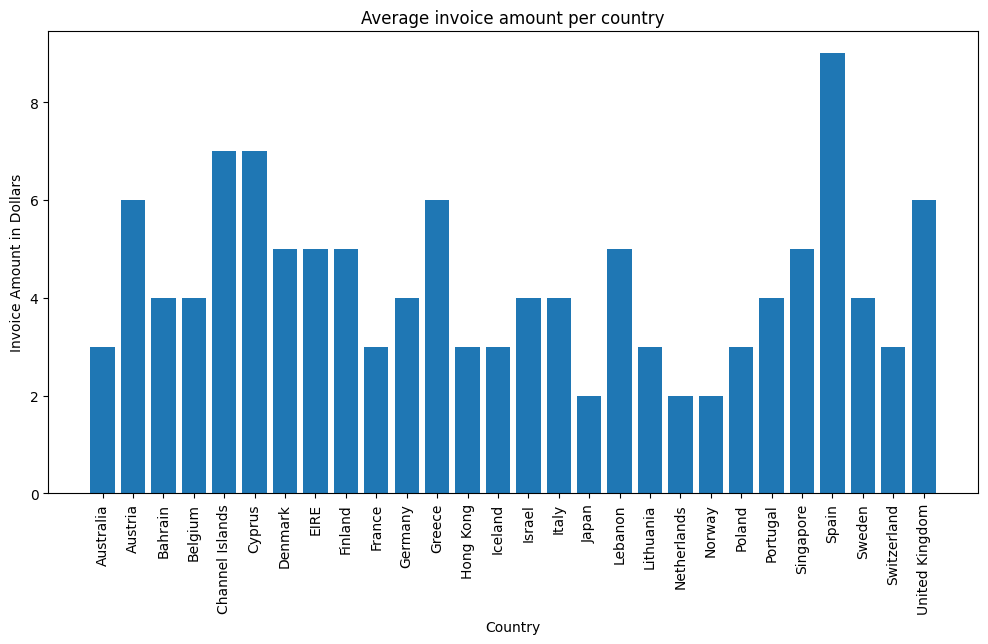

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [5]:
#invoice amount per country average
invoice_amount_by_country = round(countries_grouped['UnitPrice'].agg(np.average))
# create bar plot
fig = plt.figure(figsize =(12,6))
plt.bar(invoice_amount_by_country.index, invoice_amount_by_country)
plt.xlabel('Country')
plt.ylabel("Invoice Amount in Dollars")
plt.title("Average invoice amount per country")
plt.xticks(rotation = 90)
plt.show()
print(data.columns)

In [38]:
# create new data frame and csv file put according to customer
def customer_sort():
  customer_data = []
  invoice_dates = []
  unique_customers = data['CustomerID'].unique()

  for customer_id in unique_customers:
      customer_subset = data[data['CustomerID'] == customer_id]
      today = datetime.today()

      # Get customer country
      customer_country = str(customer_subset['Country'].unique())
      # Calculate RFM metrics
      recency = (customer_subset['Recency']-4216).min()
      customer_invoices = customer_subset['InvoiceNo'].count()
      invoice_amount = customer_subset['UnitPrice'].mean()
      total_amount = customer_subset['UnitPrice'].sum()
      invoice_quantities = customer_subset['Quantity'].mean()

      # Append customer data to the list
      customer_data.append([customer_id, customer_country, customer_invoices, invoice_amount, total_amount, invoice_quantities, recency])

  # Create a DataFrame from the collected customer data
  customer_frame = pd.DataFrame(customer_data, columns=['ID', 'Country', 'Total Orders', 'Average Amount', 'Total Amount', 'Average Quantities', 'Recency'])

  # Save the customer data as a CSV file
  customer_frame.to_csv('customer_data.csv', index=False)
  # return customer_frame
  return customer_frame







In [37]:
# rfmq model to rate each of the customers
sorted_customer = customer_sort()
quantiles = sorted_customer.quantile(q=[0.10,0.30,0.60,0.75,0.90])
quantiles.to_dict()
print(quantiles)
# quartiles_dictionary = {0.25:5, }
# def rfmq(x,p,d):
#   if total_orders in sorted_customer['Total Orders']:

# Arguments (x = value, p = recency, d = quartiles dict)
def RecencyScore(x,p,d):
    if x <= d[p][0.10]:
        return 5
    elif x <= d[p][0.30]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
# Arguments (x = value,  p=(monetary_value, frequency, quantity)  k = quartiles dict)

def MFQScore(x,p,d):
    if x <= d[p][0.10]:
        return 1
    elif x <= d[p][0.30]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.75]:
        return 4
    else:
        return 5

sorted_customer['Recency Rating'] = sorted_customer['Recency'].apply(RecencyScore, args=('Recency',quantiles,))
sorted_customer['Amount Rating'] = sorted_customer['Total Amount'].apply(MFQScore, args=('Total Amount',quantiles,))
sorted_customer['Frequency Rating'] = sorted_customer['Total Orders'].apply(MFQScore, args=('Total Orders',quantiles,))
sorted_customer['Quantity Rating'] = sorted_customer['Average Quantities'].apply(MFQScore, args=('Average Quantities',quantiles,))


<ipython-input-37-63ba75cb1e43>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = sorted_customer.quantile(q=[0.10,0.30,0.60,0.75,0.90])


            ID  Total Orders  Average Amount  Total Amount  \
0.10  12902.20           7.0        1.690600        20.754   
0.30  14110.30          21.0        2.373544        63.806   
0.60  15884.20          58.0        3.255740       180.534   
0.75  16778.25         102.0        3.897209       302.110   
0.90  17685.90         212.0        5.386781       666.550   

      Average Quantities  Recency  
0.10            2.922202     32.0  
0.30            6.447648     46.0  
0.60           10.948947    101.0  
0.75           14.008333    174.0  
0.90           25.132251    284.0  


<bound method NDFrame.head of            ID             Country  Total Orders  Average Amount  Total Amount  \
0     17850.0  ['United Kingdom']           312        3.924712       1224.51   
1     13047.0  ['United Kingdom']           196        4.072959        798.30   
2     12583.0          ['France']           251        3.152510        791.28   
3     13748.0  ['United Kingdom']            28        3.996429        111.90   
4     15100.0  ['United Kingdom']             6       10.950000         65.70   
...       ...                 ...           ...             ...           ...   
4368  13436.0  ['United Kingdom']            12        5.830000         69.96   
4369  15520.0  ['United Kingdom']            18        1.724444         31.04   
4370  13298.0  ['United Kingdom']             2        3.750000          7.50   
4371  14569.0  ['United Kingdom']            12        3.920000         47.04   
4372  12713.0         ['Germany']            38        2.503421         95.13  

In [44]:
# Assign weights to each metric [recency, amount, frequency, quantities]
# i am assigning more value to customers who buy more frequently and the amount they spend
# and lesser weight values to recency and quantities bought

weights = [0.6, 0.8, 1, 0.5]


# Calculate the weighted average for each customer
sorted_customer['Overall Customer Rating'] = sorted_customer[['Recency Rating', 'Amount Rating',
                                                       'Frequency Rating', 'Quantity Rating']].mul(weights).mean(axis=1)

# Sort the customers based on the RatingScore in descending order
sorted_customers = sorted_customer.sort_values('Overall Customer Rating', ascending=False)
sorted_customers.head
sorted_customers.to_csv("rated customers.csv")


In [83]:
# now lets look at our most valuable customers
# lets say the top 1000 what goods do they buy the most, whats the value of those goods
# lets build a csv for these products

# grab top 1000 ID's
top_customers_ids = []
# loop through all id's in our rated and sorted customer dataframe
for customer_id in sorted_customers['ID']:
  # grab top 1000 id's
  if len(top_customers_ids) <= 1000:
    # append top 1000 to list
    top_customers_ids.append(customer_id)
  else:
    # break once 1000 is reached
    break

def most_items_bought():
  # initiate the counter
    items_counter = Counter()
    # loop through our top 1000 customer id's
    for customer_id in top_customers_ids:
      # look for our id in our orginal data set
        if customer_id in data['CustomerID']:
          # if id found in original data set, grab the description of the goods bought
            items_bought = data[data['CustomerID'] == customer_id]['Description']
            # add the count for this item using our counter
            items_counter.update(items_bought)

    # Create a list to hold all the item dictionaries
    items_list = []
    # loop though all items and their count
    for item, count in items_counter.items():
        if count > 2:
          # get items unit prices for specific goods and get average price
          item_price = round((data[data['Description'] == item]['UnitPrice']).mean(), 2)
          # get total value sold for that item
          item_value = item_price * count
          # get items in dictionary and append to list
          items_dic = {"Item": item, "Count": count, "Unit Price": item_price, "Value": item_value}
          items_list.append(items_dic)

    # Specify the path and filename for the CSV file
    csv_filename = 'top1000customers_items_data.csv'

    # Open the CSV file in write mode
    with open(csv_filename, 'w', newline='') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=['Item', 'Count', 'Unit Price', 'Value'])
      # Write the header row
      writer.writeheader()
      # Write each dictionary row to the CSV file
      writer.writerows(items_list)

most_items_bought()


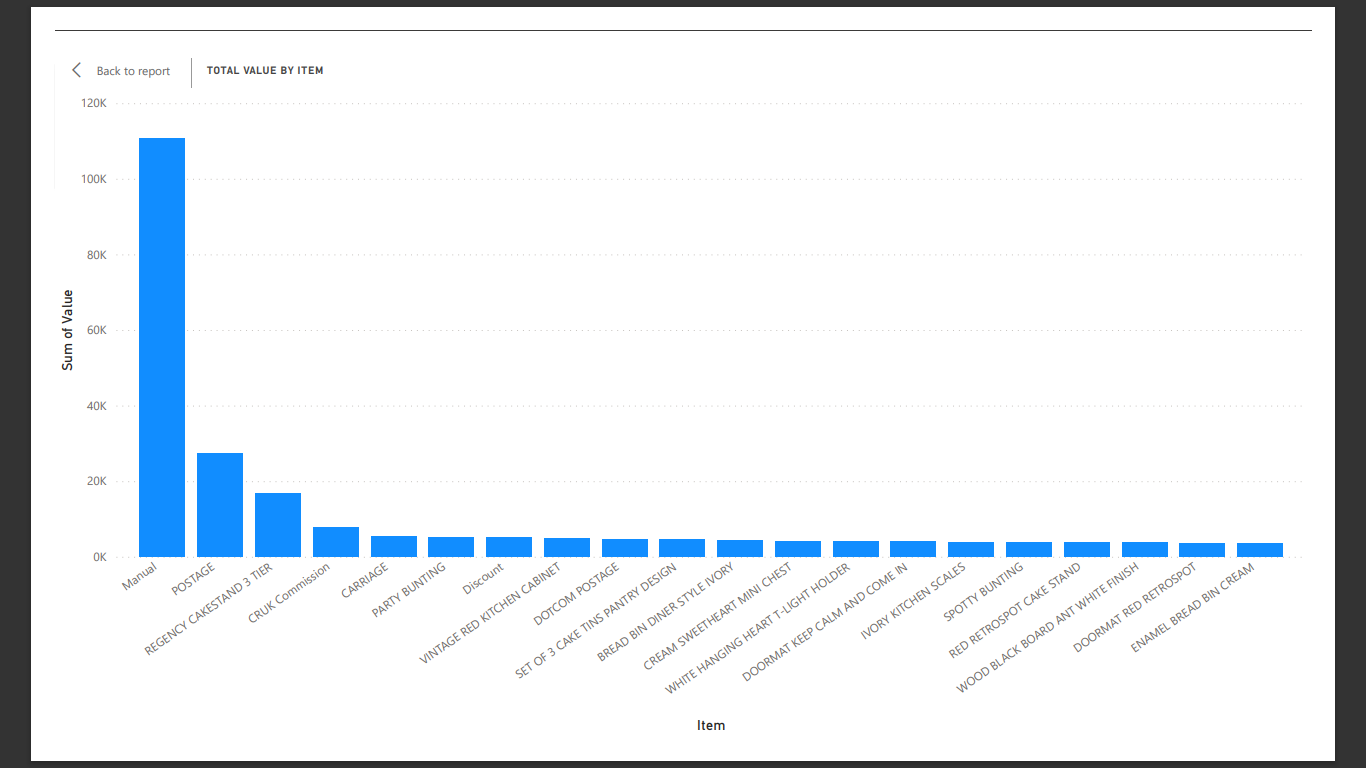